Importing packages

In [19]:
import os
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, SimilarityTransform, warp
from skimage.color import rgb2gray, rgb2hed
from skimage import exposure

from data_loader import load_HnE_image

Loading data

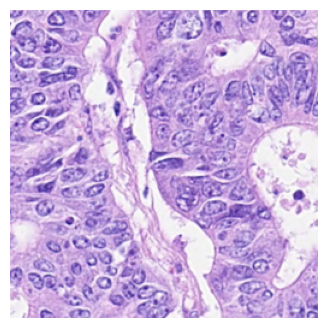

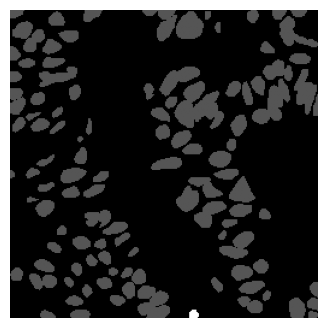

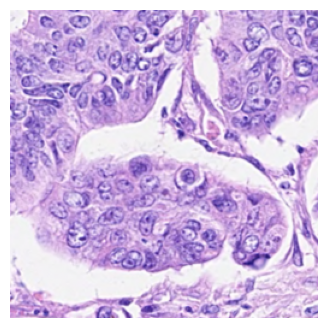

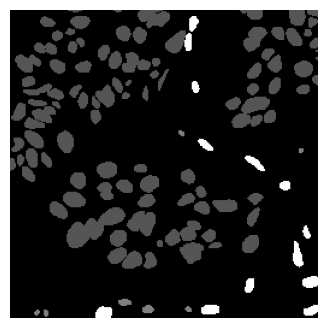

In [12]:
folder_path = "../../../Thesis_Data/OME-TIFFs"

images_data, labels_data = load_HnE_image(folder_path)

def display_image(image, values_scaled=False):
    if image.ndim == 3 and image.shape[0] == 3: 
        image = image.transpose(1, 2, 0)         
    if not values_scaled:
        image = image.astype(float)
        image = image / image.max()
    plt.figure(figsize=(4, 4))
    if image.ndim == 2:  
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image(images_data[0])
display_image(labels_data[0])
display_image(images_data[1])
display_image(labels_data[1])


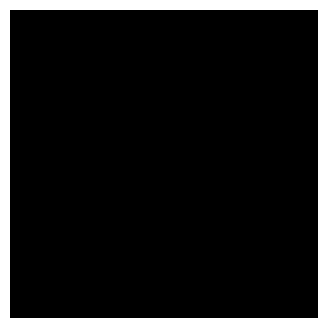

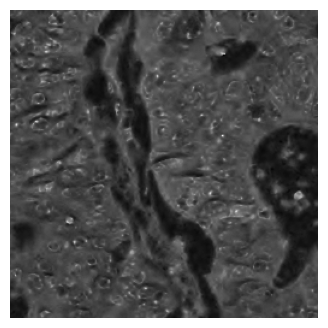

C:\Users\tckum\AppData\Local\Temp\ipykernel_34316\4082114143.py:10: RuntimeWarning: invalid value encountered in divide
  image = image / image.max()


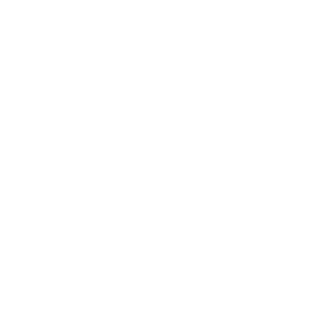

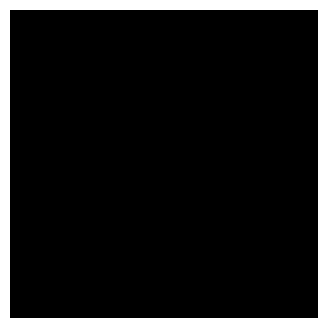

In [29]:
# Using hematoxylin channel 
hed = rgb2hed(images_data[0].transpose(1, 2, 0))
hematoxylin = hed[:, :, 0]
display_image(hematoxylin, values_scaled=True)
display_image(hed[:, :, 1], values_scaled=False)
display_image(hed[:, :, 2], values_scaled=False)

hematoxylin_enhanced = exposure.equalize_adapthist(hematoxylin, clip_limit=0.03)
display_image(hematoxylin_enhanced)

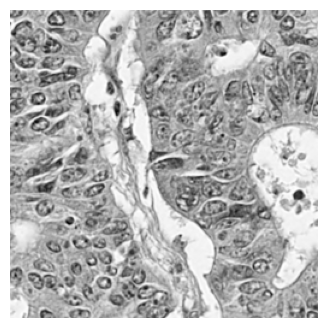

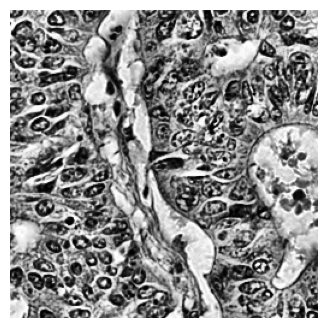

In [32]:
# using gray scale 
gray_image = rgb2gray(images_data[0].transpose(1, 2, 0))
display_image(gray_image)

image = gray_image.astype(float)
gray_image = image / image.max()
gray_enhanced = exposure.equalize_adapthist(gray_image, clip_limit=0.03)
display_image(gray_enhanced)

Applying Transformations

[[ 0.98006658 -0.19866933  0.        ]
 [ 0.19866933  0.98006658  1.        ]
 [ 0.          0.          1.        ]]


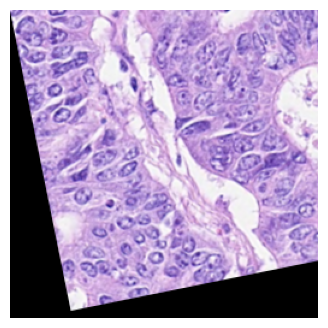

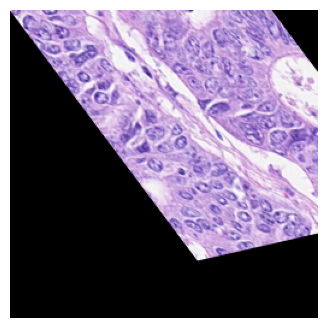

In [33]:
tform = SimilarityTransform(scale=1, rotation=0.2, translation=(0, 1))
print(tform.params)

tform2 = AffineTransform(scale=(1.2, 1.2), rotation=0.2, translation=(0, 1), shear=0.5)

warped_image = warp(images_data[0].transpose(1, 2, 0), tform)
warped_image2 = warp(images_data[0].transpose(1, 2, 0), tform2)
display_image(warped_image)
display_image(warped_image2)

Registration

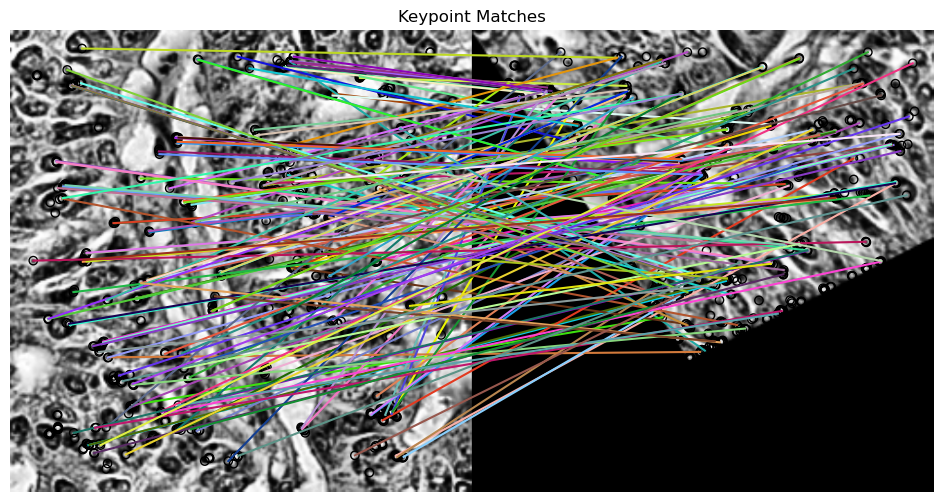

Number of matches: 173


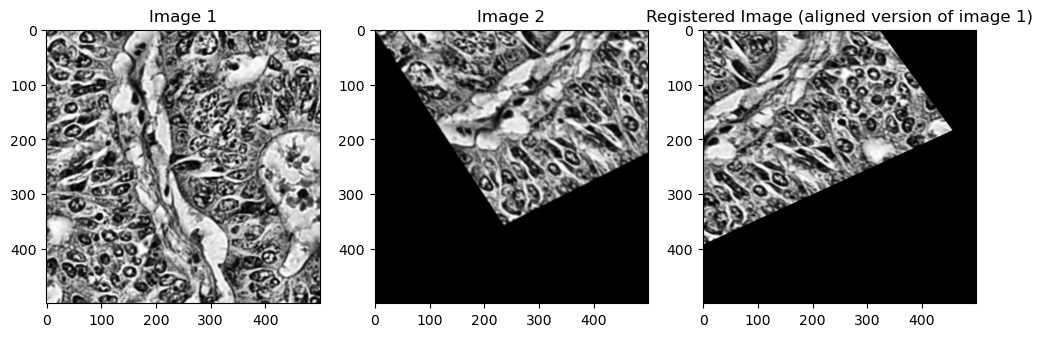

In [36]:
# using ORB and RANSAC for registration

import matplotlib.pyplot as plt
from skimage.feature import ORB, match_descriptors, plot_matched_features
from skimage.transform import AffineTransform, warp, resize
from skimage.measure import ransac

# Load images
image1 = gray_enhanced
tform = AffineTransform(scale=(1, 1), rotation=2, shear=0.2, translation=(200, 0))
image2 = warp(image1, tform)

# Resize images to be the same size
image1 = resize(image1, (500, 500), anti_aliasing=True)
image2 = resize(image2, (500, 500), anti_aliasing=True)

# Initialize ORB detector
orb = ORB(n_keypoints=500)

# Detect features and descriptors
orb.detect_and_extract(image1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Match descriptors
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)

# Extract matched keypoints
src = keypoints1[matches[:, 0]]
dst = keypoints2[matches[:, 1]]

# Plot keypoints and matches
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.gray()
plot_matched_features(image1, image2, keypoints0=keypoints1, keypoints1=keypoints2, matches=matches, ax=ax)
ax.axis('off')
ax.set_title("Keypoint Matches")
plt.show()

# Verify number of matches
print(f"Number of matches: {len(matches)}")

# Check if we have enough matches to compute a reliable transformation
if len(matches) < 4:
    raise ValueError("Not enough matches to compute a reliable transformation")

# Compute affine transformation using RANSAC for robustness
model_robust, inliers = ransac((dst, src),
                               AffineTransform, min_samples=4,
                               residual_threshold=2, max_trials=1000)

# Warp image
registered_image = warp(image1, model_robust.inverse, output_shape=image2.shape)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(image1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Image 2')
plt.imshow(image2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Registered Image (aligned version of image 1)')
plt.imshow(registered_image, cmap='gray')

plt.show()